# Do Cross-Correlations with Ambient Noise

## General Overview & Pre-Processing Options of Ambient Noise Tomography
### Goal: Retrieve the Estimated Green's Functions


## Adapted From Last Week:

### Let's do some ambient noise stuff (could be earthquake source problems, receiver functions)

The basic idea of Ambient Noise Tomography (ANT) is that by computing the cross-correlation of the records at two stations (given some important requirements that will not be discussed here)you obtain a waveform this is proportional to the Green's function between the two stations. 

In the frequency domain, the cross-spectrum
\begin{equation}
S_{xy} = \hat{X}^\ast(f)*\hat{Y}(f)
\end{equation}
where the $X^\ast$ represents the complex-conjugate of $X$.

Note that unlike the power spectra
\begin{equation}
S_{xx} = \hat{X}^\ast(f)*\hat{X}(f)
\end{equation}

the cross-spectrum is complex-valued. If you take the iFFT of the cross-spectrum, it is equivalent to the cross-correlation between two signals in the time domain. 

The codes below try to show you how the correlation function can be obtained using the FFT. As you will see, some sort of normalization is needed. 




In [1]:
# Imports...
import obspy
import numpy as np
import scipy
import scipy.signal as scisignal
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Image

import pandas as pd

import os
import glob


#make a figure without it being interactive..
%matplotlib inline

In [3]:
# YOUR information... paths, etc

#main dir
mdir='/uufs/chpc.utah.edu/common/home/flin-group4/emberg/ROSES/Unit4_XCorr'

#dir with Raw Data (mseed files)
datadir=mdir #mdir+'/RawData'



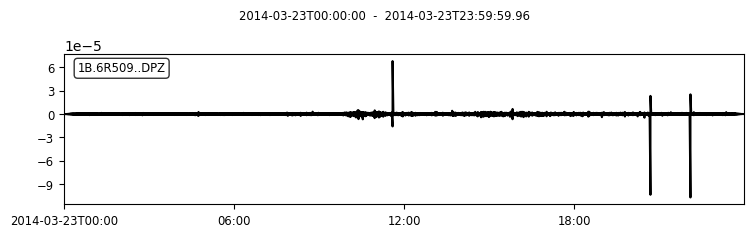

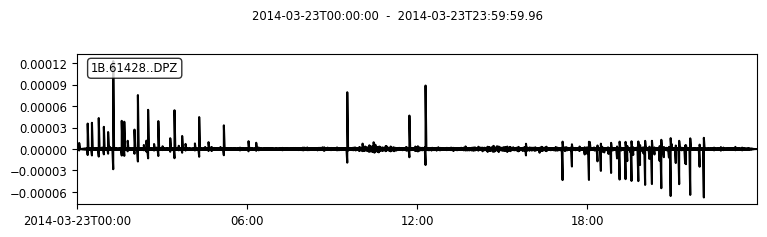

In [4]:
# Get an example file combo

srcsta='6R509'
recsta='61428'

srcst=obspy.read(datadir+'/'+srcsta+'.LHZ.mseed')
recst=obspy.read(datadir+'/'+recsta+'.LHZ.mseed')

srcst.plot()
recst.plot()


Text(0.5, 1.0, 'Station 61428')

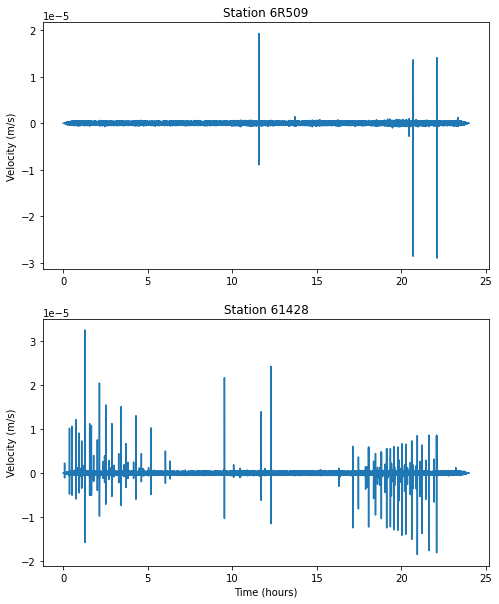

In [5]:
# Reminder of the filters we learned last week, courtesy of Prof German Prieto

tr1    = srcst[0]
src   = tr1.data
tr2    = recst[0]
rec    = tr2.data
dt4    = tr1.stats.delta
nx4    = tr1.stats.npts   
t      = np.arange(nx4)*dt4 

# Create a Butterworth filter
#   Define nyquist and scale frequencies
fmin = 0.01
fmax = 0.4
fnyq = 0.5/dt4
f0   = fmin/fnyq
f1   = fmax/fnyq
wn   = [f0,f1] 

# Create filter, and apply filter to both traces
b, a = scisignal.butter(4, wn,'bandpass')
x4   = scisignal.filtfilt(b, a, src)
y4   = scisignal.filtfilt(b, a, rec)



# Plot data
fig = plt.figure(figsize = (8,10))
ax = fig.add_subplot(211)
ax.plot(t/3600,x4)
ax.set_ylabel('Velocity (m/s)');
ax.set_title('Station '+srcsta)
ax2 = fig.add_subplot(212)
ax2.plot(t/3600,y4)
ax2.set_xlabel('Time (hours)');
ax2.set_ylabel('Velocity (m/s)');
ax2.set_title('Station '+recsta)

In [27]:
print(tr1.stats.delta)

0.04


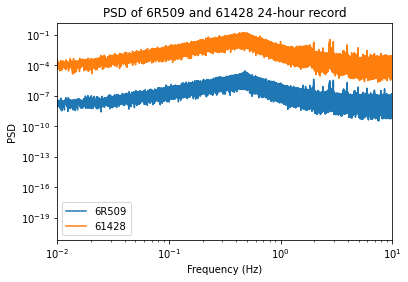

In [6]:
#Let's look at the Power Spectral Density (covered in last few sessions..)

x4    = scisignal.detrend(src,type='constant')
y4    = scisignal.detrend(rec, type='constant')
xvar4 = np.var(x4)
yvar4 = np.var(y4)

# Calculate PSD (hanning taper), with padding. 
npts   = nx4
npts2  = 2*npts+1   # make padding odd. 
nf4    = int((npts2+1)/2)   
hann   = np.hanning(npts)
freq4  = np.fft.fftfreq(npts2,dt4)
df4    = freq4[1]

# Taper signals
dat_x4         = np.zeros(npts2)
dat_x4[0:npts] = x4*hann
dat_y4         = np.zeros(npts2)
dat_y4[0:npts] = y4*hann

# Get PSD, for ease we will not normalize.  
fx4   = np.fft.fft(dat_x4,npts2)
Px4   = abs(fx4)**2
fy4   = np.fft.fft(dat_y4,npts2)
Py4   = abs(fy4)**2

# Apply a smoothing operator, improve variance. 
nsmooth = 10
Px4_smooth = np.convolve(Px4, np.ones(nsmooth)/nsmooth)
Py4_smooth = np.convolve(Py4, np.ones(nsmooth)/nsmooth)

# Plot results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(abs(freq4[0:nf4]),Px4_smooth[0:nf4],label=srcsta)
ax.loglog(abs(freq4[0:nf4]),Py4_smooth[0:nf4]*5000,label=recsta)
ax.legend()
ax.set_xlim(0.01, 10);
ax.set_xlabel('Frequency (Hz)');
ax.set_ylabel('PSD');
ax.set_title('PSD of '+srcsta+' and '+recsta+' 24-hour record')
plt.show()

tdel: [-86400.04       -86399.99999998 -86399.95999996 ...  86399.95999996
  86399.99999998  86400.04      ]


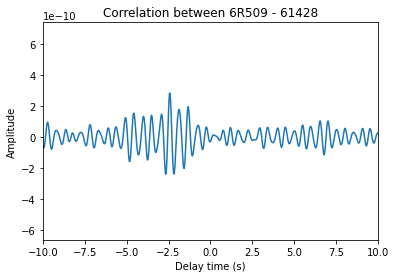

In [7]:
# Whole day cross-correlation & filter to desired frequency containing signal (around 2Hz here)
import obspy.signal.filter #use this if playing with the Obspy filter..

# Compute the cross spectrum, ifft to get cross-correlation
Sxy    = np.conj(fx4)*fy4 #fx4*np.conj(fy4)
xycorr = np.real(scipy.fft.ifft(Sxy))
xycorr = scipy.fft.ifftshift(xycorr)

# Delay time vector
tdel  = np.linspace(-nf4*dt4,nf4*dt4,npts2)
print('tdel:',tdel)

# Filter cross-correlation
# freq in Hz
fmin=1.5
fmax = 2.5

fnyq = 0.5/dt4
f0   = fmin/fnyq
f1   = fmax/fnyq
wn   = [f0,f1] 
b, a = scisignal.butter(4, wn,'bandpass')

#filter with Butterworth from last week
xycorr_filt = scisignal.filtfilt(b, a, xycorr)

#nofilter..
#xycorr_filt=xycorr

# filter with obspy.. This is an option, too!
#xycorr_filt=obspy.signal.filter.bandpass(np.array(xycorr),freqmin=1.5,freqmax=2.5,df=25,corners=4,zerophase=True)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tdel,xycorr_filt)
#ax.set_xlim(-150, 150);
ax.set_xlim(-10, 10);
ax.set_xlabel('Delay time (s)');
ax.set_ylabel('Amplitude');
ax.set_title('Correlation between '+srcsta+' - '+recsta)
plt.show()

In [8]:
# let's loop through hour-long windows and see the impact of stacking..

#import scipy.fft.*

#Loop over 1 hour segments, correlate, and stack
corrlen=100 #total delay for the correlation
nminutes=60 #number of minutes in cross-correlation
winlen=int(nminutes*60/dt4) #convert from minutes to nsamples

hourinds=np.arange(0,len(src),winlen)
outsamples=int(corrlen/dt4)

xcmatrix=[]



for ii in range(len(hourinds)-1):
    print('on time index: ',ii)
    starti=hourinds[ii]
    stopi=hourinds[ii+1]
    
    #Cut the traces to winlen
    ttsrc=src[starti:stopi]
    ttrec=rec[starti:stopi]
    
    ## Pre-Processing (demean, detrend, temporal normalization, spectral whitening, etc) ##
    #1. Demean
    x4    = scisignal.detrend(ttsrc,type='constant')
    y4    = scisignal.detrend(ttrec, type='constant')
    
    print('demean complete')
    
    #2. Detrend
    x4    = scisignal.detrend(x4,type='linear')
    y4    = scisignal.detrend(y4, type='linear')
    
    print('demean and detrend complete')
    
    # Calculate hanning taper info, with padding. 
    if ii==0:
        #no sense in getting these more than the inital run-through as should not change
        npts   = len(ttsrc)#nx4
        npts2  = 2*npts+1   # make padding odd. 
        
        #fun trick!
        npts2=scipy.fftpack.next_fast_len(npts2) #get faster array length for fft purposes
        
        nf4    = int((npts2+1)/2)  #cross-correlation window length 
        hann   = np.hanning(npts)
        
        #Don't need this, so skip following 2 lines here, included for reference
        #freq4  = np.fft.fftfreq(npts2,dt4) #return discrete fourier transform sample frequencies
        #df4    = freq4[1]
        
        
    #3. Taper signals, add padding
    dat_x4         = np.zeros(npts2)
    dat_x4[0:npts] = x4*hann
    dat_y4         = np.zeros(npts2)
    dat_y4[0:npts] = y4*hann
    
    print('taper complete..')

    # FFT of data
    fx4   = np.fft.fft(dat_x4,npts2)
    fy4   = np.fft.fft(dat_y4,npts2)
    
    print('applying fft complete')
    
    #Correlate
    Sxy    = np.conj(fx4)*fy4
    xycorr = np.real(scipy.fft.ifft(Sxy))
    xycorr = scipy.fft.ifftshift(xycorr)
    
    print('correlation complete')

    # Delay time vector, same as above.. only run on the first round
    if ii==0:
        tdel  = np.linspace(-nf4*dt4,nf4*dt4,npts2)

    xcmatrix.append(xycorr)
    
    


on time index:  0
demean complete
demean and detrend complete
taper complete..
applying fft complete
correlation complete
on time index:  1
demean complete
demean and detrend complete
taper complete..
applying fft complete
correlation complete
on time index:  2
demean complete
demean and detrend complete
taper complete..
applying fft complete
correlation complete
on time index:  3
demean complete
demean and detrend complete
taper complete..
applying fft complete
correlation complete
on time index:  4
demean complete
demean and detrend complete
taper complete..
applying fft complete
correlation complete
on time index:  5
demean complete
demean and detrend complete
taper complete..
applying fft complete
correlation complete
on time index:  6
demean complete
demean and detrend complete
taper complete..
applying fft complete
correlation complete
on time index:  7
demean complete
demean and detrend complete
taper complete..
applying fft complete
correlation complete
on time index:  8
demean

Text(0.5, 0, 'Time (s)')

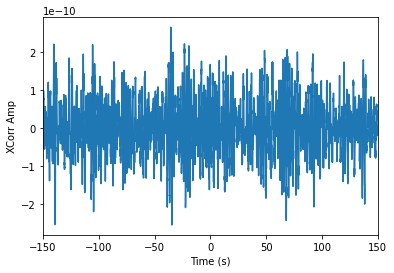

In [9]:
#check things look ok for a random hour.. Perhaps the 15th hour?

plt.plot(tdel,xcmatrix[15])
plt.xlim(-150,150)
plt.ylabel('XCorr Amp')
plt.xlabel('Time (s)')

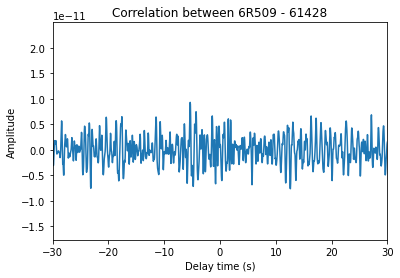

In [10]:
#apply a filter and plot a single hour (the last hour)

fmin=1.0
fmax = 2.5
fmax=5

fnyq = 0.5/dt4
f0   = fmin/fnyq
f1   = fmax/fnyq
wn   = [f0,f1] 
b, a = scisignal.butter(4, wn,'bandpass')
xycorr_filt = scisignal.filtfilt(b, a, xycorr) #note xycorr is the last hour we computed

# Included for reference..
#nofilter..
#xycorr_filt=xycorr
# filter with obspy..
#xycorr_filt=obspy.signal.filter.bandpass(np.array(xycorr),freqmin=1.5,freqmax=2.5,df=25,corners=4,zerophase=True)

#make a figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tdel,xycorr_filt)
ax.set_xlim(-30, 30);
ax.set_xlabel('Delay time (s)');
ax.set_ylabel('Amplitude');
ax.set_title('Correlation between '+srcsta+' - '+recsta)
plt.show()


In [11]:
#next, stack & plot (see the impact of stacking before we do any extra pre-processing steps)


#output fig files after each hour of stacking
outfigdir=datadir+'/StackHours'
if not os.path.isdir(outfigdir):
    os.mkdir(outfigdir)

### CAREFUL! ###
#remove previous files -- CAREFUL!
pngfiles=glob.glob(outfigdir+'/*png')
for f in pngfiles:
    os.remove(f)


    
#Compute sum -- this is empty for now, we will add to it!
sumxc=xcmatrix[0]*0

#bandpass info (applied when plotting, not in stack)
fmin = 1.5 #2.5s
fmax=2.5
fnyq = 0.5/dt4
f0   = fmin/fnyq
f1   = fmax/fnyq
wn   = [f0,f1] 
b, a = scisignal.butter(4, wn,'bandpass')

# count the hours
ic=0


#initiate figure that we will write over
fig=plt.figure(3,figsize=[10,5])

for xc in xcmatrix:
    
    #normalize each hour so each contributes evenly
    sumxc=sumxc+np.multiply(1/np.max(np.abs(xc)),xc)
    
    
    #great! Now bandpass this signal...
    sumxctmp = scisignal.filtfilt(b, a, sumxc)
    
    #can also use obspy...
    #sumxctmp=obspy.signal.filter.bandpass(np.array(sumxc),freqmin=1.5,freqmax=2.5,df=25,corners=4,zerophase=True)
    
    
    sumxctmp=np.multiply(1/np.max(np.abs(sumxctmp)),sumxctmp) #normalize
    
    #make the figures...
    plt.plot(tdel,sumxctmp);
    plt.ylim(-1,1)
    plt.xlim(-20,20)
    ic=ic+1;
    
    ### NOTE that if the gif comes out in a not-correct order, you can instead try one of the following ###
    #      (every OS is different, so this may take some trial & error): 
    # 1. icstr='%d' % (ic); outf=outfigdir+'/corr'+icstr.zfill(3)+'.png'
    # 2. icstr='%5.0f' % (ic); outf=outfigdir+'/corr'+icstr.zfill(3)+'.png'
    # 3. icstr='%5.0f' % (ic); outf=outfigdir+'/corr_00'+icstr.zfill(3)+'.png'
    # You can also see how your OS lists the png files in the dir they are located and use that as an idea of the order
    #   the png's will probably be combined below.
    plt.title('Hours Stacked: '+str(ic))
    outf=outfigdir+'/corr'+str(ic).zfill(3)+'.png'
    plt.savefig(outf)
    plt.clf()



<Figure size 720x360 with 0 Axes>

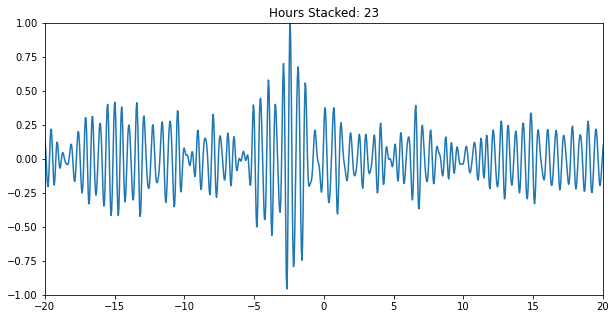

In [12]:
#plot just the final stack..

fmin = 1.5
fmax=2.5
fnyq = 0.5/dt4
f0   = fmin/fnyq
f1   = fmax/fnyq
wn   = [f0,f1] 
b, a = scisignal.butter(4, wn,'bandpass')

fig=plt.figure(4,figsize=[10,5])
#filter the final result..
#sumxctmp=obspy.signal.filter.bandpass(np.array(sumxc),freqmin=1.5,freqmax=2.5,df=25,corners=4,zerophase=True)
sumxctmp = scisignal.filtfilt(b, a, sumxc)
sumxctmp=np.multiply(1/np.max(np.abs(sumxctmp)),sumxctmp) #normalize

#plot it up..
plt.plot(tdel,sumxctmp);
plt.ylim(-1,1)
plt.xlim(-20,20)
plt.title('Hours Stacked: '+str(ic))
plt.show()


In [13]:
#convert from png's to a gif
from PIL import Image

frames=[]
imgs=glob.glob(outfigdir+'/*.png')
for i in imgs:
    new_frame=Image.open(i)
    frames.append(new_frame)
    
frames[0].save(outfigdir+'/Src_Rec_Hours.gif',format='GIF',append_images=frames[1:],save_all=True,duration=300,loop=0)

print('completed gif! Location:',outfigdir+'/Src_Rec_Hours.gif')


completed gif! Location: /uufs/chpc.utah.edu/common/home/flin-group4/emberg/ROSES/Unit4_XCorr/StackHours/Src_Rec_Hours.gif


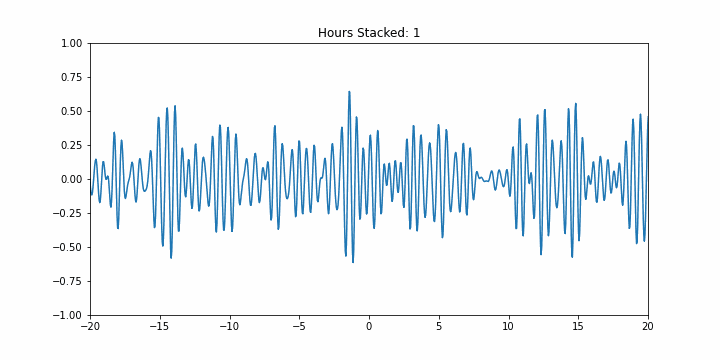

In [14]:
#Look at the gif
from IPython.display import Image

#insert the outputfigdir+'/'Src_Rec_Hours.gif (or whatever name you chose) from output of above cell
stream='/uufs/chpc.utah.edu/common/home/flin-group4/emberg/ROSES/Unit4_XCorr/StackHours/Src_Rec_Hours.gif'#'/uufs/chpc.utah.edu/common/home/flin-group4/emberg/ROSES/Unit4_XCorr/RawData/StackHours/Src_Rec_Hours.gif'

Image(stream)




# Temporal Normalization Options

*Note that there are **many** ways to apply temporal normalization to you data, and sometimes it is not needed!* 

*Please discuss in the Slack Unit4 section if you use temporal normalization, which techniques you find works best, and why or why not!*

## Option 1: remove spikes, or associations with Earthquakes 

There are multiple ways to do this, so please discuss in the slack (discard window, zero & taper around detected signal, etc)!

For example: Remove all signals if > threshold, remove length of time around detected signal > threshold, etc

## Option 2: 1-Bit Normalization (what it sounds like)

## Option 3: Running mean - multiple ways to do this

1. Bandpass to 15-50s (band containing energetic surface wave signals from earthquakes [Lin et al., 2007])
2. Mean of absolute value from seismogram computed in 128s window centered on this point [Lin et al., 2007]

*Have a different preference? Share in the Slack!*


In [ ]:
# Option 1: Detect & remove spikes [do on your own, and/or discuss in the Slack]
# we will skip this due to time


on time index:  0
correlation complete
on time index:  1
correlation complete
on time index:  2
correlation complete
on time index:  3
correlation complete
on time index:  4
correlation complete
on time index:  5
correlation complete
on time index:  6
correlation complete
on time index:  7
correlation complete
on time index:  8
correlation complete
on time index:  9
correlation complete
on time index:  10
correlation complete
on time index:  11
correlation complete
on time index:  12
correlation complete
on time index:  13
correlation complete
on time index:  14
correlation complete
on time index:  15
correlation complete
on time index:  16
correlation complete
on time index:  17
correlation complete
on time index:  18
correlation complete
on time index:  19
correlation complete
on time index:  20
correlation complete
on time index:  21
correlation complete
on time index:  22
correlation complete
finished xcorr!


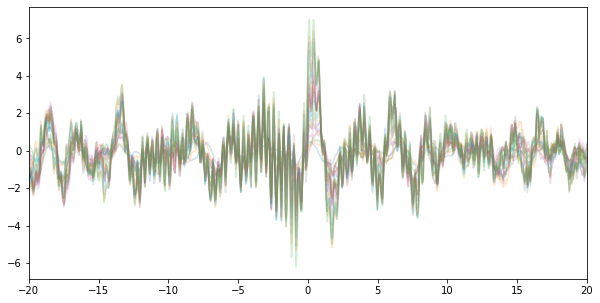

finished stacking! onto the plot..


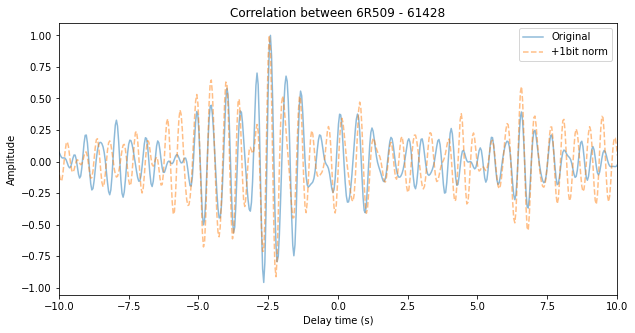

In [15]:
# Option 2: 1-Bit Normalization

# Loop through the windows & apply 1-bit normalization before cross-correlating, stack result for comparison

#Loop over 1 hour segments, correlate, and stack
corrlen=100 #total delay for the correlation
nminutes=60 #number of minutes in cross-correlation
winlen=int(nminutes*60/dt4) #convert from minutes to nsamples

hourinds=np.arange(0,len(src),winlen)
outsamples=int(corrlen/dt4)

xcmatrix_1bit=[]



for ii in range(len(hourinds)-1):
    print('on time index: ',ii)
    starti=hourinds[ii]
    stopi=hourinds[ii+1]
    
    #Cut the traces to winlen
    ttsrc=src[starti:stopi]
    ttrec=rec[starti:stopi]
    
    ## Pre-Processing (demean, detrend, temporal normalization, spectral whitening, etc) ##
    #1. Demean
    x4    = scisignal.detrend(ttsrc,type='constant')
    y4    = scisignal.detrend(ttrec, type='constant')
    
    #print('demean complete')
    
    #2. Detrend
    x4    = scisignal.detrend(x4,type='linear')
    y4    = scisignal.detrend(y4, type='linear')
    
    #print('demean and detrend complete')
    
    # Calculate hanning taper info, with padding. 
    if ii==0:
        #no sense in getting these more than the inital run-through as should not change
        npts   = len(ttsrc)#nx4
        npts2  = 2*npts+1   # make padding odd. 
        npts2=scipy.fftpack.next_fast_len(npts2) #get faster array length for fft purposes
        
        nf4    = int((npts2+1)/2)  #cross-correlation window length 
        hann   = np.hanning(npts)
        
        
    #3. Taper signals, add padding
    dat_x4 = np.zeros(npts2)
    dat_y4 = np.zeros(npts2)
    
    #### NEW!!!!!!!!!! #######
    # Apply 1-bit normalization after taper #
    dat_x4[0:npts] = np.sign(x4*hann)
    dat_y4[0:npts] = np.sign(y4*hann)
    
    #print('taper complete..')
    

    # FFT of data
    fx4   = np.fft.fft(dat_x4,npts2)
    fy4   = np.fft.fft(dat_y4,npts2)
    
    #print('applying fft complete')
    
    #Correlate
    Sxy    = np.conj(fx4)*fy4
    xycorr = np.real(scipy.fft.ifft(Sxy))
    xycorr = scipy.fft.ifftshift(xycorr)
    
    print('correlation complete')

    if ii==0:
        tdel  = np.linspace(-nf4*dt4,nf4*dt4,npts2)

    xcmatrix_1bit.append(xycorr)
    

print('finished xcorr!')


### COMBINE EVERYTHING TOGETHER TO RUN QUICKLY ###

# stack results 
fig=plt.figure(5,figsize=[10,5])
sumxc_1bit=xcmatrix_1bit[0]*0
for xc in xcmatrix_1bit:
    sumxc_1bit=sumxc_1bit+np.multiply(1/np.max(np.abs(xc)),xc)
    
    plt.plot(tdel,sumxc_1bit,alpha=0.2)
    plt.xlim(-20,20)
plt.show()
print('finished stacking! onto the plot..')

# plot final bp of stack

fmin=1.5
fmax = 2.5 #2.5s

fnyq = 0.5/dt4
f0   = fmin/fnyq
f1   = fmax/fnyq
wn   = [f0,f1] 
b, a = scisignal.butter(4, wn,'bandpass')

xcorr_filt = scisignal.filtfilt(b, a, sumxc)
xcorr1b_filt = scisignal.filtfilt(b, a, sumxc_1bit)

#normalize
xcorr_filt=np.multiply(1/np.max(np.abs(xcorr_filt)),xcorr_filt) #normalize
xcorr1b_filt=np.multiply(1/np.max(np.abs(xcorr1b_filt)),xcorr1b_filt) #normalize

#nofilter..
#xycorr_filt=xycorr

# filter with obspy..
#xycorr_filt=obspy.signal.filter.bandpass(np.array(xycorr),freqmin=1.5,freqmax=2.5,df=25,corners=4,zerophase=True)

fig=plt.figure(6,figsize=[10,5])
ax = fig.add_subplot(111)
ax.plot(tdel,xcorr_filt,label='Original',alpha=0.5)
ax.plot(tdel,xcorr1b_filt,label='+1bit norm',alpha=0.5,linestyle='--')
ax.legend()
ax.set_xlim(-10, 10);
ax.set_xlabel('Delay time (s)');
ax.set_ylabel('Amplitude');
ax.set_title('Correlation between '+srcsta+' - '+recsta)
plt.show()


## Let's take a second to think about running-means here

on time index:  0


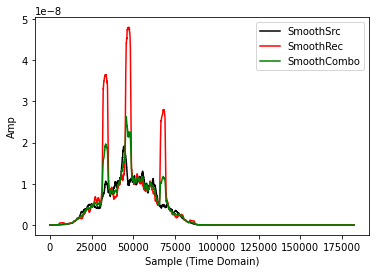

In [17]:
# test out the running mean..

#Loop over 1 hour segments, correlate, and stack
corrlen=100 #total delay for the correlation
nminutes=60 #number of minutes in cross-correlation
winlen=int(nminutes*60/dt4) #convert from minutes to nsamples

hourinds=np.arange(0,len(src),winlen)
outsamples=int(corrlen/dt4)

xcmatrix_cohe=[]


# we will look at just one hour (notice the 'break' in the loop below)
for ii in range(len(hourinds)-1):
    print('on time index: ',ii)
    starti=hourinds[ii]
    stopi=hourinds[ii+1]
    
    #Cut the traces to winlen
    ttsrc=src[starti:stopi]
    ttrec=rec[starti:stopi]
    
    ## Pre-Processing (demean, detrend, temporal normalization, spectral whitening, etc) ##
    #1. Demean
    x4    = scisignal.detrend(ttsrc,type='constant')
    y4    = scisignal.detrend(ttrec, type='constant')
    
    #print('demean complete')
    
    #2. Detrend
    x4    = scisignal.detrend(x4,type='linear')
    y4    = scisignal.detrend(y4, type='linear')
    
    #print('demean and detrend complete')
    
    # Calculate hanning taper info, with padding. 
    if ii==0:
        #no sense in getting these more than the inital run-through as should not change
        npts   = len(ttsrc)#nx4
        npts2  = 2*npts+1   # make padding odd. 
        npts2=scipy.fftpack.next_fast_len(npts2) #get faster array length for fft purposes
        
        nf4    = int((npts2+1)/2)  #cross-correlation window length 
        hann   = np.hanning(npts)
        #freq4  = np.fft.fftfreq(npts2,dt4) #return discrete fourier transform sample frequencies
        #df4    = freq4[1]
        
        
    #3. Taper signals, add padding
    dat_x4 = np.zeros(npts2)
    dat_y4 = np.zeros(npts2)
    dat_x4[0:npts] = x4*hann
    dat_y4[0:npts] = y4*hann
    
    
    #plt.plot(dat_x4[0:npts])
    
    break


#Frequencies expect surface waves to contaminate signal from earthquakes (Lin et al., 2007)...    
eqfmin=0.02 #50s
eqfmax =0.067 #15s

eqtempx=obspy.signal.filter.bandpass(np.array(dat_x4),freqmin=eqfmin,freqmax=eqfmax,df=25,corners=4,zerophase=True)
eqtempy=obspy.signal.filter.bandpass(np.array(dat_y4),freqmin=eqfmin,freqmax=eqfmax,df=25,corners=4,zerophase=True)

eqsmoothN=int(128/dt4) #get samples to smooth over..

#cheap rma..
#more information on this application of rma (described nicely by lapis on stackoverflow):
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean

eq_smoothx = np.convolve(np.abs(eqtempx), np.ones(eqsmoothN)/eqsmoothN,mode='same')
eq_smoothy = np.convolve(np.abs(eqtempy), np.ones(eqsmoothN)/eqsmoothN,mode='same')
eq_smooth=np.sqrt(eq_smoothx*eq_smoothy)

dat2_x4= dat_x4/(eq_smooth)
dat2_y4= dat_y4/(eq_smooth)


#plot...

#plt.plot(np.abs(eqtempx),label='RawSrc',alpha=0.5,c='k')
#plt.plot(np.abs(eqtempy),label='RawRec',alpha=0.5,c='r')
plt.plot(eq_smoothx,c='k',label='SmoothSrc')
plt.plot(eq_smoothy,c='r',label='SmoothRec')
plt.plot(eq_smooth,c='g',label='SmoothCombo')
plt.xlabel('Sample (Time Domain)')
plt.ylabel('Amp')
plt.legend()

plt.show()


on time index:  0
on time index:  1
on time index:  2
on time index:  3
on time index:  4
on time index:  5
on time index:  6
on time index:  7
on time index:  8
on time index:  9
on time index:  10
on time index:  11
on time index:  12
on time index:  13
on time index:  14
on time index:  15
on time index:  16
on time index:  17
on time index:  18
on time index:  19
on time index:  20
on time index:  21
on time index:  22
finished xcorr!
finished stacking! onto the plot..


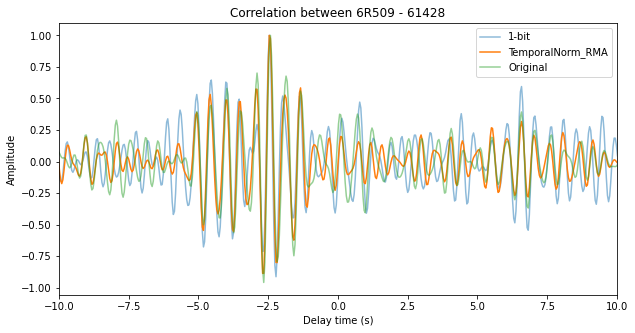

In [18]:
# Option 3: RMA temporal normalization
#bandpass to 15-50s (band containing energetic surface wave signals from earthquakes [Lin et al., 2007])
#Mean of absolute value from seismogram computed in 128s window centered on this point [Lin et al., 2007]
eqfmin=0.02 #50s
eqfmax =0.067 #15s


#Loop over 1 hour segments, correlate, and stack
corrlen=100 #total delay for the correlation
nminutes=60 #number of minutes in cross-correlation
winlen=int(nminutes*60/dt4) #convert from minutes to nsamples

hourinds=np.arange(0,len(src),winlen)
outsamples=int(corrlen/dt4)

xcmatrix_trma=[]



for ii in range(len(hourinds)-1):
    print('on time index: ',ii)
    starti=hourinds[ii]
    stopi=hourinds[ii+1]
    
    #Cut the traces to winlen
    ttsrc=src[starti:stopi]
    ttrec=rec[starti:stopi]
    
    ## Pre-Processing (demean, detrend, temporal normalization, spectral whitening, etc) ##
    #1. Demean
    x4    = scisignal.detrend(ttsrc,type='constant')
    y4    = scisignal.detrend(ttrec, type='constant')
    
    #print('demean complete')
    
    #2. Detrend
    x4    = scisignal.detrend(x4,type='linear')
    y4    = scisignal.detrend(y4, type='linear')
    
    #print('demean and detrend complete')
    
    # Calculate hanning taper info, with padding. 
    if ii==0:
        #no sense in getting these more than the inital run-through as should not change
        npts   = len(ttsrc)#nx4
        npts2  = 2*npts+1   # make padding odd. 
        npts2=scipy.fftpack.next_fast_len(npts2) #get faster array length for fft purposes
        
        nf4    = int((npts2+1)/2)  #cross-correlation window length 
        hann   = np.hanning(npts)
        #freq4  = np.fft.fftfreq(npts2,dt4) #return discrete fourier transform sample frequencies
        #df4    = freq4[1]
        
        
    #3. Taper signals, add padding
    dat_x4 = np.zeros(npts2)
    dat_y4 = np.zeros(npts2)
    dat_x4[0:npts] = x4*hann
    dat_y4[0:npts] = y4*hann
    
    #print('taper complete..')
    
    
    ### NEW! Temporal Normalization!!!!! ###
    #Now do temporal normalization
    eqtempx=obspy.signal.filter.bandpass(np.array(dat_x4),freqmin=eqfmin,freqmax=eqfmax,df=25,corners=4,zerophase=True)
    eqtempy=obspy.signal.filter.bandpass(np.array(dat_y4),freqmin=eqfmin,freqmax=eqfmax,df=25,corners=4,zerophase=True)

    eqsmoothN=int(128/dt4) #get samples to smooth over..

    #cheap rma..
    eq_smoothx = np.convolve(np.abs(eqtempx), np.ones(eqsmoothN)/eqsmoothN,mode='same')
    eq_smoothy = np.convolve(np.abs(eqtempy), np.ones(eqsmoothN)/eqsmoothN,mode='same')
    eq_smooth=np.sqrt(eq_smoothx*eq_smoothy)

    dat_x4= dat_x4/(eq_smooth)
    dat_y4= dat_y4/(eq_smooth)
    # End of New Section #

    

    # FFT of data
    fx4   = np.fft.fft(dat_x4,npts2)
    fy4   = np.fft.fft(dat_y4,npts2)
    
    
    #Correlate
    Sxy    = np.conj(fx4)*fy4
    xycorr = np.real(scipy.fft.ifft(Sxy))
    xycorr = scipy.fft.ifftshift(xycorr)
    
    
    #print('correlation complete')

    # Delay time vector, same as above.. only run on the first round
    #tdel  = np.linspace(-nf4,nf4,npts2)
    if ii==0:
        tdel  = np.linspace(-nf4*dt4,nf4*dt4,npts2)

    xcmatrix_trma.append(xycorr)
    

print('finished xcorr!')
    
# stack results 
sumxc_trma=xcmatrix_trma[0]*0
for xc in xcmatrix_trma:
    sumxc_trma=sumxc_trma+np.multiply(1/np.max(np.abs(xc)),xc)
print('finished stacking! onto the plot..')

# plot final bp of stack

fmin=1.5
fmax = 2.5

fnyq = 0.5/dt4
f0   = fmin/fnyq
f1   = fmax/fnyq
wn   = [f0,f1] 
b, a = scisignal.butter(4, wn,'bandpass')

xcorr_filt = scisignal.filtfilt(b, a, sumxc)
xcorrTRMA_filt = scisignal.filtfilt(b, a, sumxc_trma)
xcorr1b_filt = scisignal.filtfilt(b, a, sumxc_1bit)

#normalize
xcorr_filt=np.multiply(1/np.max(np.abs(xcorr_filt)),xcorr_filt) #normalize
xcorr1b_filt=np.multiply(1/np.max(np.abs(xcorr1b_filt)),xcorr1b_filt) #normalize
xcorrTRMA_filt=np.multiply(1/np.max(np.abs(xcorrTRMA_filt)),xcorrTRMA_filt) #normalize



fig=plt.figure(6,figsize=[10,5])
ax = fig.add_subplot(111)

ax.plot(tdel,xcorr1b_filt,label='1-bit',alpha=0.5)
ax.plot(tdel,xcorrTRMA_filt,label='TemporalNorm_RMA',alpha=1.0,linestyle='-')
ax.plot(tdel,xcorr_filt,label='Original',alpha=0.5)

ax.legend()
ax.set_xlim(-10, 10);
ax.set_xlabel('Delay time (s)');
ax.set_ylabel('Amplitude');
ax.set_title('Correlation between '+srcsta+' - '+recsta)
plt.show()


*Thoughts on temporal normalization? Please add to the Discussion in the Slack for this Channel!*

# Spectral Whitening

This was discussed in the previous homework from last week from Prof German Prieto, and included again below.

*Again, please discuss in the Slack if you have used any of these techniques, and which you have found to be useful (how/why?) -- and which you have not (how/why?)!*

As you will see, some sort of normalization [in the frequency domain] is needed. For example, Bensen et al. (200?) suggest to prewhiten the signals before correlation, that is
\begin{equation}
X_{norm}(f) = \frac{\hat{X}(f)}{<S_{xx}(f)>}
\end{equation}
where the $<\cdot>$ represents some sort of averaged, or smoothed version of the term inside. Similar for $Y$, and then calculate the cross spectrum. 

This is equivalent to what is known as the coherency:
\begin{equation}
C_{xy}(f) = \frac{S_{xy}(f)}{\sqrt{<S_{xx}(f)><S_{yy}(f)>}}
\end{equation}



### Compute the normalized correlation instead (coherency)

To get a better behaved, broad band GF, we normalize the the PSD of both signals. In principle, similar to Bensen et al. 

on time index:  0
on time index:  1
on time index:  2
on time index:  3
on time index:  4
on time index:  5
on time index:  6
on time index:  7
on time index:  8
on time index:  9
on time index:  10
on time index:  11
on time index:  12
on time index:  13
on time index:  14
on time index:  15
on time index:  16
on time index:  17
on time index:  18
on time index:  19
on time index:  20
on time index:  21
on time index:  22
finished xcorr!
finished stacking! onto the plot..


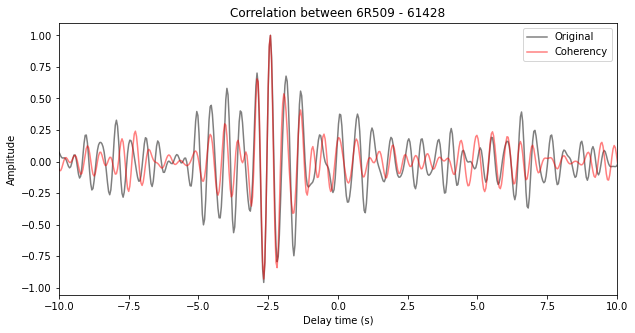

In [19]:
# Spectral Whitening: Coherency

#Loop over 1 hour segments, correlate, and stack
corrlen=100 #total delay for the correlation
nminutes=60 #number of minutes in cross-correlation
winlen=int(nminutes*60/dt4) #convert from minutes to nsamples

hourinds=np.arange(0,len(src),winlen)
outsamples=int(corrlen/dt4)

xcmatrix_cohe=[]



for ii in range(len(hourinds)-1):
    print('on time index: ',ii)
    starti=hourinds[ii]
    stopi=hourinds[ii+1]
    
    #Cut the traces to winlen
    ttsrc=src[starti:stopi]
    ttrec=rec[starti:stopi]
    
    ## Pre-Processing (demean, detrend, temporal normalization, spectral whitening, etc) ##
    #1. Demean
    x4    = scisignal.detrend(ttsrc,type='constant')
    y4    = scisignal.detrend(ttrec, type='constant')
    
    #print('demean complete')
    
    #2. Detrend
    x4    = scisignal.detrend(x4,type='linear')
    y4    = scisignal.detrend(y4, type='linear')
    
    #print('demean and detrend complete')
    
    # Calculate hanning taper info, with padding. 
    if ii==0:
        #no sense in getting these more than the inital run-through as should not change
        npts   = len(ttsrc)#nx4
        npts2  = 2*npts+1   # make padding odd. 
        npts2=scipy.fftpack.next_fast_len(npts2) #get faster array length for fft purposes
        
        nf4    = int((npts2+1)/2)  #cross-correlation window length 
        hann   = np.hanning(npts)
        #freq4  = np.fft.fftfreq(npts2,dt4) #return discrete fourier transform sample frequencies
        #df4    = freq4[1]
        
        
    #3. Taper signals, add padding
    dat_x4 = np.zeros(npts2)
    dat_y4 = np.zeros(npts2)
    dat_x4[0:npts] = x4*hann
    dat_y4[0:npts] = y4*hann
    
    #print('taper complete..')
    

    # FFT of data
    fx4   = np.fft.fft(dat_x4,npts2)
    fy4   = np.fft.fft(dat_y4,npts2)
    
    Px4   = abs(fx4)**2
    Py4   = abs(fy4)**2
    
    # Apply a smoothing operator, improve variance. 
    nsmooth = 10
    Px4_smooth = np.convolve(Px4, np.ones(nsmooth)/nsmooth)
    Py4_smooth = np.convolve(Py4, np.ones(nsmooth)/nsmooth)
    
    #print('applying fft complete')
    
    #Correlate
    Sxy    = np.conj(fx4)*fy4
    
    #### NEW!!!! Coherency!!! ####
    cohe = Sxy/(np.sqrt(Px4_smooth[0:npts2])*np.sqrt(Py4_smooth[0:npts2]))
    xycorr = np.real(scipy.fft.ifft(cohe))
    xycorr = scipy.fft.ifftshift(xycorr)
    
    
    #print('correlation complete')

    # Delay time vector, same as above.. only run on the first round
    if ii==0:
        tdel  = np.linspace(-nf4*dt4,nf4*dt4,npts2)

    xcmatrix_cohe.append(xycorr)
    

print('finished xcorr!')
    
# stack results 
sumxc_cohe=xcmatrix_cohe[0]*0
for xc in xcmatrix_cohe:
    sumxc_cohe=sumxc_cohe+np.multiply(1/np.max(np.abs(xc)),xc)
print('finished stacking! onto the plot..')

# plot final bp of stack

fmin=1.5
fmax = 2.5 #2.5s

fnyq = 0.5/dt4
f0   = fmin/fnyq
f1   = fmax/fnyq
wn   = [f0,f1] 
b, a = scisignal.butter(4, wn,'bandpass')

xcorr_filt = scisignal.filtfilt(b, a, sumxc)
xcorrCohe_filt = scisignal.filtfilt(b, a, sumxc_cohe)


#normalize
xcorr_filt=np.multiply(1/np.max(np.abs(xcorr_filt)),xcorr_filt) #normalize
xcorrCohe_filt=np.multiply(1/np.max(np.abs(xcorrCohe_filt)),xcorrCohe_filt) #normalize

#nofilter..
#xycorr_filt=xycorr

# filter with obspy..
#xycorr_filt=obspy.signal.filter.bandpass(np.array(xycorr),freqmin=1.5,freqmax=2.5,df=25,corners=4,zerophase=True)


#Make a figure
fig=plt.figure(6,figsize=[10,5])
ax = fig.add_subplot(111)
ax.plot(tdel,xcorr_filt,label='Original',alpha=0.5,c='k')
ax.plot(tdel,xcorrCohe_filt,label='Coherency',alpha=0.5,linestyle='-',c='r')
ax.legend()
ax.set_xlim(-10, 10);
ax.set_xlabel('Delay time (s)');
ax.set_ylabel('Amplitude');
ax.set_title('Correlation between '+srcsta+' - '+recsta)
plt.show()


In [24]:
#Making a series of images going through each hour and stacking...

#next, stack & plot (see the impact of stacking before we do any extra pre-processing steps)


#output fig files after each hour of stacking
outfigdir=datadir+'/StackHoursCoherency'
if not os.path.isdir(outfigdir):
    os.mkdir(outfigdir)
    
    
# CAREFUL!!!! #########################
#remove previous files -- CAREFUL!
pngfiles=glob.glob(outfigdir+'/*png')
for f in pngfiles:
    os.remove(f)


    
#%%
#Compute sum
sumxc_cohe=xcmatrix_cohe[0]*0

#bandpass info (applied when plotting, not in stack)
fmin = 1.5 #2.5s
fmax=2.5
fnyq = 0.5/dt4
f0   = fmin/fnyq
f1   = fmax/fnyq
wn   = [f0,f1] 
b, a = scisignal.butter(4, wn,'bandpass')

# count the hours
ic=0

fig=plt.figure(3,figsize=[10,5])
for xc in xcmatrix_cohe:
    
    sumxc_cohe=sumxc_cohe+np.multiply(1/np.max(np.abs(xc)),xc)
    
    #great! Now bandpass this signal...
    sumxctmp = scisignal.filtfilt(b, a, sumxc_cohe)
    #sumxctmp=obspy.signal.filter.bandpass(np.array(sumxc),freqmin=1.5,freqmax=2.5,df=25,corners=4,zerophase=True)
    
    sumxctmp=np.multiply(1/np.max(np.abs(sumxctmp)),sumxctmp) #normalize
    
    plt.plot(tdel,sumxctmp);
    #plt.ylim( -1*(max(abs(sumxctmp))), max(abs(sumxctmp)))
    plt.ylim(-1,1)
    plt.xlim(-20,20)
    ic=ic+1;
    plt.title('Coherency -- Hours Stacked: '+str(ic))
    icstr='%5.0f' % (ic)
    outf=outfigdir+'/corr_Cohe_'+icstr.zfill(3)+'.png'
    plt.savefig(outf)
    plt.clf()



<Figure size 720x360 with 0 Axes>

In [25]:
#convert from png's to a gif
from PIL import Image

frames=[]
imgs=glob.glob(outfigdir+'/*.png')
for i in imgs:
    new_frame=Image.open(i)
    frames.append(new_frame)

#output the gif...
frames[0].save(outfigdir+'/Src_Rec_HoursCoherency.gif',format='GIF',append_images=frames[1:],save_all=True,duration=300,loop=0)

print('completed making gif, see: ',outfigdir+'/Src_Rec_HoursCoherency.gif')


completed making gif, see:  /uufs/chpc.utah.edu/common/home/flin-group4/emberg/ROSES/Unit4_XCorr/StackHoursCoherency/Src_Rec_HoursCoherency.gif


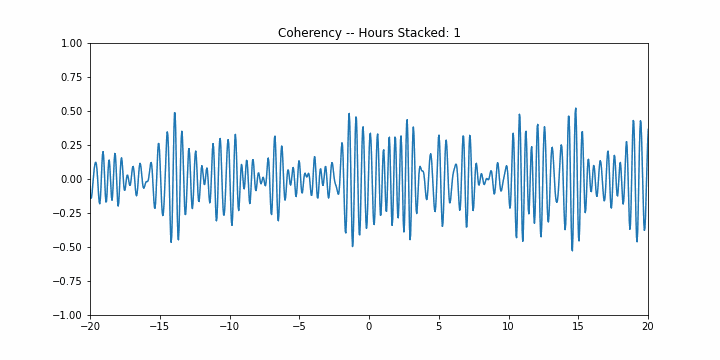

In [26]:
#Look at the gif
from IPython.display import Image

#use the output from the cell above for the stream
stream='/uufs/chpc.utah.edu/common/home/flin-group4/emberg/ROSES/Unit4_XCorr/StackHoursCoherency/Src_Rec_HoursCoherency.gif'#'/uufs/chpc.utah.edu/common/home/flin-group4/emberg/ROSES/Unit4_XCorr/RawData/StackHoursCoherency/Src_Rec_Hours.gif'

Image(stream)



*From Prof German Prieto's notes from last week.*

**Note that all of these methods have been included below, but please pick one and compare!**
**Together we will try Method 3**

### Deconvolution interferometry 

Because there was a questions about this, let's add a water-level, to stabilize the deconvolution. 

We will try the three ways of deconvolution netod here (there are many opther methods. I personally prefer the multitaper method, but that is me. 

- Method 1
\begin{equation}
T_{xy}(f) = \frac{X(f)}{Y(f)}
\end{equation}

- Method 2
\begin{equation}
T_{xy}(f) = \frac{X^\ast(f)Y(f)}{Y(f)Y^\ast(f)}=\frac{S_{xy}(f)}{<S_{yy}(f)>} 
\end{equation}

- Method 3
\begin{equation}
T_{xy}(f) = \frac{S_{xy}(f)}{<S_{yy}>(f)+W_L} 
\end{equation}




on time index:  0
on time index:  1
on time index:  2
on time index:  3
on time index:  4
on time index:  5
on time index:  6
on time index:  7
on time index:  8
on time index:  9
on time index:  10
on time index:  11
on time index:  12
on time index:  13
on time index:  14
on time index:  15
on time index:  16
on time index:  17
on time index:  18
on time index:  19
on time index:  20
on time index:  21
on time index:  22
finished xcorr!
finished stacking! onto the plot..


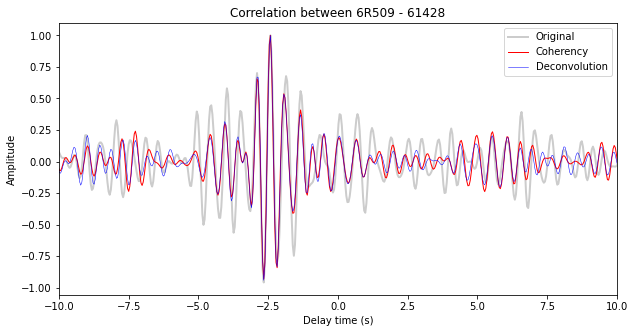

In [23]:
# Spectral Whitening: Deconvolution


# Two water-levels
WL3 = 1e-11
WL4 = 1e-15


#Loop over 1 hour segments, correlate, and stack
corrlen=100 #total delay for the correlation
nminutes=60 #number of minutes in cross-correlation
winlen=int(nminutes*60/dt4) #convert from minutes to nsamples

hourinds=np.arange(0,len(src),winlen)
outsamples=int(corrlen/dt4)

xcmatrix_deconv=[]



for ii in range(len(hourinds)-1):
    print('on time index: ',ii)
    starti=hourinds[ii]
    stopi=hourinds[ii+1]
    
    #Cut the traces to winlen
    ttsrc=src[starti:stopi]
    ttrec=rec[starti:stopi]
    
    ## Pre-Processing (demean, detrend, temporal normalization, spectral whitening, etc) ##
    #1. Demean
    x4    = scisignal.detrend(ttsrc,type='constant')
    y4    = scisignal.detrend(ttrec, type='constant')
    
    #print('demean complete')
    
    #2. Detrend
    x4    = scisignal.detrend(x4,type='linear')
    y4    = scisignal.detrend(y4, type='linear')
    
    #print('demean and detrend complete')
    
    # Calculate hanning taper info, with padding. 
    if ii==0:
        #no sense in getting these more than the inital run-through as should not change
        npts   = len(ttsrc)#nx4
        npts2  = 2*npts+1   # make padding odd. 
        npts2=scipy.fftpack.next_fast_len(npts2) #get faster array length for fft purposes
        
        nf4    = int((npts2+1)/2)  #cross-correlation window length 
        hann   = np.hanning(npts)
        #freq4  = np.fft.fftfreq(npts2,dt4) #return discrete fourier transform sample frequencies
        #df4    = freq4[1]
        
        
    #3. Taper signals, add padding
    dat_x4 = np.zeros(npts2)
    dat_y4 = np.zeros(npts2)
    
    dat_x4[0:npts] = x4*hann
    dat_y4[0:npts] = y4*hann
    
    #print('taper complete..')
    

    # FFT of data
    fx4   = np.fft.fft(dat_x4,npts2)
    fy4   = np.fft.fft(dat_y4,npts2)
    
    Px4   = abs(fx4)**2
    Py4   = abs(fy4)**2
    
    # Apply a smoothing operator, improve variance. 
    nsmooth = 10
    Px4_smooth = np.convolve(Px4, np.ones(nsmooth)/nsmooth)
    Py4_smooth = np.convolve(Py4, np.ones(nsmooth)/nsmooth)
    
    # The cross spectrum
    Sxy   = np.conj(fx4)*fy4

    # DECONVOLUTION! #########################
    #Pick a Method! 
    # Method 1 (uncomment below)
    #Tx1   = fx4/fy4
    #irf1  = np.real(scipy.fft.ifft(Tx1))
    #xycorr  = scipy.fft.ifftshift(irf1)

    # Method 2 (uncomment below)
    #Tx2   = Sxy/(Py4_smooth[0:npts2])
    #irf2  = np.real(scipy.fft.ifft(Tx2))
    #xycorr  = scipy.fft.ifftshift(irf2)

    # Method 3 (uncomment below)
    Tx3   = Sxy/(Py4_smooth[0:npts2]+WL3)
    irf3  = np.real(scipy.fft.ifft(Tx3))
    xycorr  = scipy.fft.ifftshift(irf3)

    # Method 3 (uncomment below)
    #Tx4   = Sxy/(Py4_smooth[0:npts2]+WL4)
    #irf4  = np.real(scipy.fft.ifft(Tx4))
    #xycorr  = scipy.fft.ifftshift(irf4)
    
    
    
    
    #print('correlation complete')

    # Delay time vector, same as above.. only run on the first round
    #tdel  = np.linspace(-nf4,nf4,npts2)
    if ii==0:
        tdel  = np.linspace(-nf4*dt4,nf4*dt4,npts2)

    xcmatrix_deconv.append(xycorr)
    

print('finished xcorr!')
    
# stack results 
sumxc_deconv=xcmatrix_deconv[0]*0
for xc in xcmatrix_deconv:
    sumxc_deconv=sumxc_deconv+np.multiply(1/np.max(np.abs(xc)),xc)
print('finished stacking! onto the plot..')

# plot final bp of stack

fmin=1.5
fmax = 2.5 #2.5s

fnyq = 0.5/dt4
f0   = fmin/fnyq
f1   = fmax/fnyq
wn   = [f0,f1] 
b, a = scisignal.butter(4, wn,'bandpass')

xcorr_filt = scisignal.filtfilt(b, a, sumxc)
xcorrDeconv_filt = scisignal.filtfilt(b, a, sumxc_deconv)


#normalize
xcorr_filt=np.multiply(1/np.max(np.abs(xcorr_filt)),xcorr_filt) #normalize
xcorrDeconv_filt=np.multiply(1/np.max(np.abs(xcorrDeconv_filt)),xcorrDeconv_filt) #normalize


#nofilter..
#xycorr_filt=xycorr

# filter with obspy..
#xycorr_filt=obspy.signal.filter.bandpass(np.array(xycorr),freqmin=1.5,freqmax=2.5,df=25,corners=4,zerophase=True)

fig=plt.figure(6,figsize=[10,5])
ax = fig.add_subplot(111)
ax.plot(tdel,xcorr_filt,label='Original',alpha=0.2,c='k',lw=2)
ax.plot(tdel,xcorrCohe_filt,label='Coherency',alpha=1.0,linestyle='-',c='r',lw=1)
ax.plot(tdel,xcorrDeconv_filt,label='Deconvolution',alpha=1,linestyle='-',c='b',lw=0.5)
ax.legend()
ax.set_xlim(-10, 10);
ax.set_xlabel('Delay time (s)');
ax.set_ylabel('Amplitude');
ax.set_title('Correlation between '+srcsta+' - '+recsta)
plt.show()


In [ ]:
#Compare spectra of results (if extra time -- please play around with this on your own, though!!!)

#For the sake of brevity, we will consider: Original, Temporal RMA, Coherency, and Deconvolution

#original case...
ft_orig  = np.fft.fft(sumxc,npts2)
ft_orig  = abs(ft_orig)**2
orig_smooth = np.convolve(ft_orig, np.ones(nsmooth)/nsmooth)

#Temporal Normalization
ft_trma  = np.fft.fft(sumxc_trma,npts2)
ft_trma  = abs(ft_trma)**2
trma_smooth = np.convolve(ft_trma, np.ones(nsmooth)/nsmooth)

# Coherency
ft_cohe  = np.fft.fft(sumxc_cohe,npts2)
ft_cohe  = abs(ft_cohe)**2
cohe_smooth = np.convolve(ft_cohe, np.ones(nsmooth)/nsmooth)

# Deconvolution
ft_deconv  = np.fft.fft(sumxc_deconv,npts2)
ft_deconv  = abs(ft_deconv)**2
deconv_smooth = np.convolve(ft_deconv, np.ones(nsmooth)/nsmooth)






fig = plt.figure(figsize = (8,10))
ax1 = fig.add_subplot(221)
ax1.loglog(abs(freq4[0:2*nf4]),orig_smooth[0:2*nf4])
#ax1.loglog(abs(freq4[0:nf4]),orig_smooth[0:nf4])
ax2 = fig.add_subplot(222)
ax2.loglog(abs(freq4[0:2*nf4]),trma_smooth[0:2*nf4])
ax3 = fig.add_subplot(223)
ax3.loglog(abs(freq4[0:2*nf4]),cohe_smooth[0:2*nf4])
ax4 = fig.add_subplot(224)
ax4.loglog(abs(freq4[0:2*nf4]),deconv_smooth[0:2*nf4])
#ax1.set_ylim(1e-3, 1e12);
#ax2.set_ylim(1e-3, 1e12);
#ax3.set_ylim(1e-3, 1e12);
#ax4.set_ylim(1e-3, 1e12);
ax1.set_xlim(0.01, 3.0);
ax2.set_xlim(0.01, 3.0);
ax3.set_xlim(0.01, 3.0);
ax4.set_xlim(0.01, 3.0);
#ax4.set_xlim(0.01, 5.0);
ax3.set_xlabel('Frequency (Hz)');
ax4.set_xlabel('Frequency (Hz)');
ax1.set_ylabel('PSD');
ax3.set_ylabel('PSD');
ax2.yaxis.tick_right()
ax4.yaxis.tick_right()
ax1.set_title('PSD Original'+srcsta+' '+recsta);
ax2.set_title('PSD Temporal Norm '+srcsta+' '+recsta);
ax3.set_title('PSD Coherency '+srcsta+' '+recsta);
ax4.set_title('PSD Deconvolution '+srcsta+' '+recsta);


